# LAB 07 Assigment

Dominik Breksa (dominikbreksa@student.agh.edu.pl)

### Project scope

...

In [1]:
"""LAB 07 Assigment Solution Notebook"""

from types import SimpleNamespace
from dataclasses import dataclass

from numba import jit, prange, float64, void, int64, set_num_threads, config
import numpy as np
import scipy
from matplotlib import pyplot as plt
from open_atmos_jupyter_utils import show_plot

In [2]:
PHYS_X0_KG = 1.192e-13
PHYS_DV_M3 = 1e6
PHYS_N0 = 2 ** 23
PHYS_B_PER_S = 1500.
PHYS_DIST = scipy.stats.expon(loc=0, scale=PHYS_X0_KG)
PHYS_NORM = PHYS_N0 * PHYS_DV_M3

COMP_N_PART = 2 ** 14
COMP_T_MAX_S = 3600
COMP_N_STEP = 1800
COMP_DT_S = COMP_T_MAX_S / COMP_N_STEP

BINS_MIN_X = -12
BINS_MAX_X = -5
BINS_COUNT = 70

RNG = np.random.default_rng(seed=42)

### ...

In [3]:
@dataclass(slots=True, eq=False)
class Particles:
    """ replacement for the dictionary to have bitwise comparison """
    mass: np.ndarray
    mult: np.ndarray

    def __eq__(self, other):
        """ bitwise compare particles """
        return isinstance(other, Particles) \
            and self.mass.tobytes() == other.mass.tobytes() \
            and self.mult.tobytes() == other.mult.tobytes()

In [4]:
def sample(u01):
    """ randomly samples a particle population using constant-multiplicity,
    uniform-mass and uniform-log-mass schemes and returns a dictionary
    of three simulation states, each composed of 'mass' and 'mult' arrays """
    u_sam_start, u_sam_end = [PHYS_DIST.ppf(q) for q in (.001, .999)]
    x_uniform_linx = (
        u_sam_start
        + u01 * (u_sam_end - u_sam_start)
    )
    x_uniform_logx = np.exp(
        np.log(u_sam_start)
        + u01 * (np.log(u_sam_end) - np.log(u_sam_start))
    )
    return {
        k: Particles(mass=v.x, mult=np.round(v.y * PHYS_NORM).astype(int))
        for k, v in
        {
            'sampling: uniform random in x': SimpleNamespace(
                x=x_uniform_linx,
                y=PHYS_DIST.pdf(x_uniform_linx) \
                  * (u_sam_end - u_sam_start) \
                  / COMP_N_PART,
            ),
            'sampling: uniform random in ln(x)': SimpleNamespace(
                x=x_uniform_logx,
                y=PHYS_DIST.pdf(x_uniform_logx) \
                  * (np.log(u_sam_end) - np.log(u_sam_start)) \
                  / (COMP_N_PART / x_uniform_logx),
            ),
            'sampling: constant multiplicity': SimpleNamespace(
                x=PHYS_DIST.ppf(u01),
                y=np.full(shape=COMP_N_PART, fill_value=1 / COMP_N_PART),
            )
        }.items()
    }

sample_u01 = RNG.uniform(0, 1, size=COMP_N_PART)

In [5]:
@jit(float64(float64, float64), nopython=True)
def kernel(mass_1, mass_2):
    """ additive coagulation kernel """
    return PHYS_B_PER_S * (mass_1 + mass_2)

def analytic_solution(mass_kg, time_s):
    """ Golovin's analytic solution to Smoluchowski coagulation equation
    for additive kernel and exponential initial condition """
    tau = 1 - np.exp(-PHYS_N0 * PHYS_B_PER_S * PHYS_X0_KG * time_s)
    sqrt_tau = np.sqrt(tau)
    return (
        (1 - tau) / (mass_kg * sqrt_tau)
        * scipy.special.ive(1, 2 * mass_kg / PHYS_X0_KG * sqrt_tau)  # pylint: disable=no-member
        * np.exp(-(1 + tau - 2 * sqrt_tau) * mass_kg / PHYS_X0_KG)
    )

In [6]:
def mass_of_x(coord):
    """ computes mass back from the plot x coordinate """
    return np.exp(3 * coord)

def plot(*, particles, time):
    """ plots the particle state as both a histogram and population scatter plot
    (with random coordinates shuffled to plot) """
    _, ax = plt.subplots(1, 1, figsize=(11, 6), tight_layout=True)
    for k in particles:
        ax.hist(
            x=np.log(particles[k].mass) / 3,
            weights=particles[k].mult / PHYS_NORM * particles[k].mass,
            bins=BINS_COUNT, range=(BINS_MIN_X, BINS_MAX_X),
            label=f'{k}', alpha=.666, density=True,
        )
    lin_x, d_x = np.linspace(BINS_MIN_X, BINS_MAX_X, 256, retstep=True)
    x_mean = lin_x[:-1] + d_x / 2
    m_mean = mass_of_x(x_mean)
    dn_dm = analytic_solution(mass_kg=m_mean, time_s=time)
    ax.plot(
        x_mean,
        dn_dm * np.diff(mass_of_x(lin_x)) / np.diff(lin_x) * PHYS_NORM * m_mean,
        color='black', label='Golovin solution'
    )
    ax.set_ylabel(r'pdf(x) $\cdot$ mass(x)')
    ax.set_xlabel(r'$x = ln(\sqrt[3]{m})$')
    ax.set_xlim(BINS_MIN_X, BINS_MAX_X)
    ax.set_title(f'time: {time:.1f} s')
    ax.legend()
    ax.grid()
    show_plot()

### Implementation of multithreading

...

In [7]:
def sdm_impl(pairs, u01, mult, mass):
    """ performs Monte-Carlo coagulation using the SDM algorithm """
    p_scale = len(mult) * (len(mult) - 1) / 2 / len(pairs) * COMP_DT_S / PHYS_DV_M3
    for alpha in prange(len(pairs)):  # pylint: disable=not-an-iterable
        j, k = pairs[alpha]
        if mult[j] < mult[k]:
            j, k = k, j

        p_alpha = mult[j] * p_scale * kernel(mass[j], mass[k])
        if u01[alpha] < (p_alpha - p_alpha // 1):
            gamma = p_alpha // 1 + 1
        else:
            gamma = p_alpha // 1

        if gamma != 0:
            gamma = min(gamma, (mult[j] / mult[k]) // 1)
            if mult[j] - gamma * mult[k] > 0:
                mult[j] -= gamma * mult[k]
                mass[k] += gamma * mass[j]
            else:
                mult[j] = mult[k] // 2
                mult[k] -= mult[j]
                mass[k] += gamma * mass[j]
                mass[j] = mass[k]

sdm_jit = jit(void(int64[:,:], float64[:], int64[:], float64[:]),
              nopython=True)(sdm_impl)
sdm_parallel = jit(void(int64[:,:], float64[:], int64[:], float64[:]),
                   nopython=True, parallel=True, nogil=True)(sdm_impl)

To make the tests possible, we need to implement the `sdm_impl` and `simulate` functions as pure (deterministic) functions.
We can do this if we calculate all the randomnesses ahead of time and then just access the randomness at given ... The randomness in these functions is required in two

In [8]:
random_u01 = RNG.uniform(0, 1, size=(COMP_N_STEP, COMP_N_PART // 2))
permutations = np.array([
    RNG.permutation(COMP_N_PART)[: 2 * (COMP_N_PART // 2)].reshape(-1, 2)
    for _ in range(COMP_N_STEP)
])

In [9]:
def simulate(*, particles, sdm_func):
    """ does simulation for all sampling variants (each variant using the same shuffled numbers) """
    for i in range(COMP_N_STEP):
        for part in particles.values():
            sdm_func(pairs=permutations[i],
                     u01=random_u01[i],
                     mult=part.mult,
                     mass=part.mass)

### About the tests

...

In [10]:
CORRECT_SIMULATION = sample(sample_u01)
simulate(particles=CORRECT_SIMULATION,
         sdm_func=sdm_impl)

In [11]:
SINGLE_THREAD_JIT = sample(sample_u01)
simulate(particles=SINGLE_THREAD_JIT,
         sdm_func=sdm_jit)
assert (test_result := CORRECT_SIMULATION == SINGLE_THREAD_JIT)
print("JIT Single Thread", test_result)

JIT Single Thread True


In [12]:
THREAD_COUNT = 1
while THREAD_COUNT < config.NUMBA_NUM_THREADS: # pylint: disable=no-member
    THREAD_COUNT *= 2
    parti = sample(sample_u01)
    set_num_threads(THREAD_COUNT)
    simulate(particles=parti,
             sdm_func=sdm_parallel)
    assert (test_result := CORRECT_SIMULATION == parti)
    print("JIT Multi Thread", THREAD_COUNT, test_result)

JIT Multi Thread 2 True
JIT Multi Thread 4 True
JIT Multi Thread 8 True
JIT Multi Thread 16 True
JIT Multi Thread 24 True


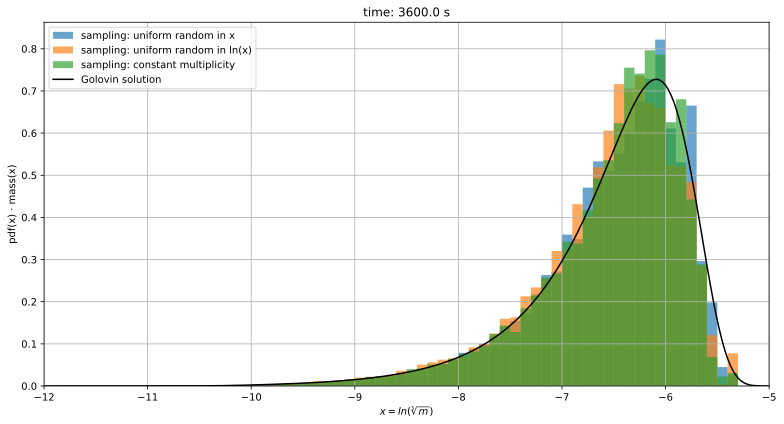

In [13]:
plot(particles=CORRECT_SIMULATION,
     time=COMP_T_MAX_S)

### Conclusions:

- Calculated solution without JIT compilation resembles the Golovin solution, meaning if the multithreaded solutions will match it exactly this no JIT solution their ....
- We can see that the bitwise information inside the mass and multiplicity vectors calculated using multiple threads is identical to their single threaded solutions. Because the experiment was performed with different thread counts, it can be concluded that there was no data race present.
- The JIT Compilation provided significant speed up of the computation on my machine from 1 minute 45 seconds to 0.537 seconds using JIT on a single thread nad 0.371 seconds with CPU parallelisation.